#### Model: 

\begin{eqnarray}
X_t & = & A X_{t-1} + \nu_t,
\\
Y_t & = & C X_t + \omega_t,
\\
\nu_t & \sim & \text{N}(0, Q ) ~~ \text{with} ~ Q = \sigma_x^2 I,
\\
\omega_t & \sim & \text{N}(0, R) ~~ \text{with} ~ R = \sigma_y^2 I.
\end{eqnarray}

In [50]:
from __future__ import division
%matplotlib inline
from pykalman import KalmanFilter
import numpy as np, numpy.random as npr, matplotlib.pyplot as plt, copy, multiprocessing as mp, pickle
from scipy.stats import *
from pylab import plot, show, legend
from tqdm import trange
from functions_linear_gaussian_HMM import *
import copy

In [2]:
A = np.asarray([[0.9, -0.3], 
                [0.2, 1]])
C = np.asarray([[-1.1, 0.5],
                [-0.3, 0.8]])
dim = np.shape(A)[0]
sigmax2 = 5e-1
sigmay2 = 5e-1
Q = sigmax2*np.eye(dim)
R = sigmay2*np.eye(dim)
mu0 = np.zeros(dim)
Sigma0 = np.eye(dim)

In [3]:
T = 1000
Y, X = generate_data_linear_gaussian(mu0, Sigma0, A, C, Q, R, T)

kf = KalmanFilter(initial_state_mean=mu0,
                  initial_state_covariance=Sigma0,
                  transition_matrices=A, 
                  observation_matrices=C, 
                  transition_covariance=Q, 
                  observation_covariance=R)
(filtered_state_means, filtered_state_covariances) = kf.filter(Y)

### Sanity checks:

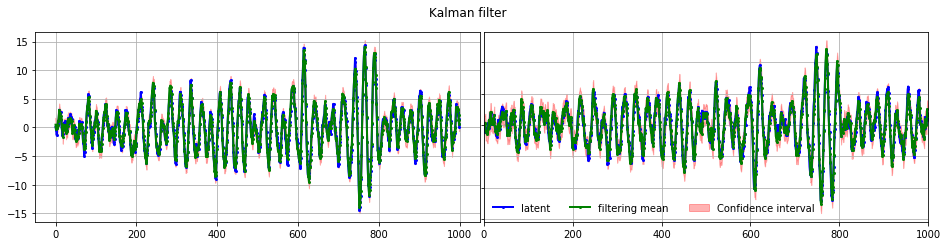

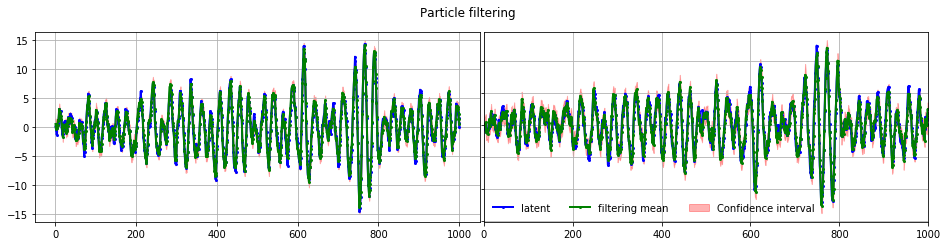

In [4]:
plt.rcParams['figure.figsize'] = (16, 3.5)
for i in range(2) :
    plt.subplot(1,2,i+1)
    plt.plot(X[:,i], "bo-", label="latent", markersize=2, linewidth=2)
    plt.plot(filtered_state_means[:,i], "go-", label="filtering mean", markersize=2, linewidth=2)
    plt.fill_between(np.arange(T), 
                     filtered_state_means[:,i] + 2*np.sqrt(filtered_state_covariances[:,i,i]), 
                     filtered_state_means[:,i] - 2*np.sqrt(filtered_state_covariances[:,i,i]), 
                     color='red', alpha=0.3, label="Confidence interval")
    if i == 1 : plt.yticks(alpha=0)
    plt.grid(True)
plt.legend(ncol=3, frameon=False)
plt.suptitle("Kalman filter")
plt.subplots_adjust(wspace=1e-2)
plt.xlim(0,T)
plt.show()

n_particles = 1000
logNC, particles = bootstrap_PF(Y, A, C, sigmax2, sigmay2, mu0, Sigma0, n_particles)

for i in range(2) :
    plt.subplot(1,2,i+1)
    plt.plot(np.arange(1,T+1), X[:,i],  "bo-", label="latent", markersize=2, linewidth=2)
    plt.plot(np.arange(1,T+1), np.mean(particles[:,:,i],axis=1), "go-", label="filtering mean", markersize=2, linewidth=2)
    plt.fill_between(np.arange(1,T+1), 
                     np.percentile(particles[:,:,i],axis=1,q=5), 
                     np.percentile(particles[:,:,i],axis=1,q=95), 
                     color='red', alpha=0.3, label="Confidence interval")
    if i == 1 : plt.yticks(alpha=0)
    plt.grid(True)
plt.legend(ncol=3, frameon=False)
plt.suptitle("Particle filtering")
plt.subplots_adjust(wspace=1e-2)
plt.xlim(0,T);

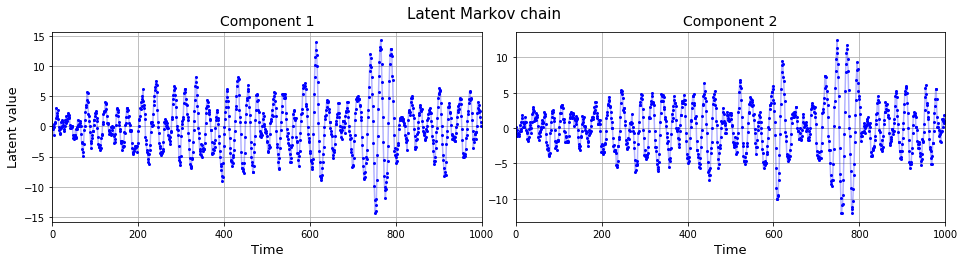

In [79]:
fig = plt.figure(figsize=(16,3.5))
for i in range(2) :
    plt.subplot(1,2,i+1)
    plt.plot(X[:,i], "b-", alpha=0.3)
    plt.plot(X[:,i], "bo", markersize=2)
    plt.grid(True)
    plt.xlim(0,T)
    plt.title("Component "+str(i+1), fontsize=14)
    plt.xlabel("Time", fontsize=13)
    if i == 0 : plt.ylabel("Latent value", fontsize=13)
plt.suptitle("Latent Markov chain", fontsize=15)
plt.subplots_adjust(wspace=8e-2)
plt.xlim(0,T)
fig.savefig('linear_gaussian_hmm_latent.pdf', bbox_inches='tight', dpi=300)

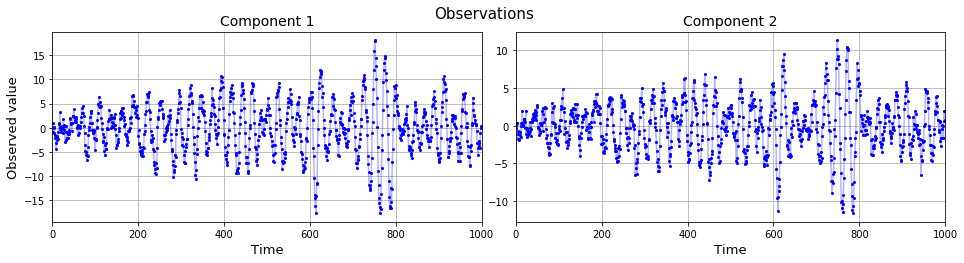

In [81]:
fig = plt.figure(figsize=(16,3.5))
for i in range(2) :
    plt.subplot(1,2,i+1)
    plt.plot(Y[:,i], "b-", alpha=0.3)
    plt.plot(Y[:,i], "bo", markersize=2)
    plt.grid(True)
    plt.xlim(0,T)
    plt.title("Component "+str(i+1), fontsize=14)
    plt.xlabel("Time", fontsize=13)
    if i == 0 : plt.ylabel("Observed value", fontsize=13)
plt.suptitle("Observations", fontsize=15)
plt.subplots_adjust(wspace=8e-2)
plt.xlim(0,T)
fig.savefig('linear_gaussian_hmm_observation.pdf', bbox_inches='tight', dpi=300)

In [52]:
dat = dict(X=X, Y=Y)
file = open("/xtmp/DC-BATS_data/linear_gaussian_HMM/data.pkl", "wb")
pickle.dump(dat, file)
file.close()

### MCMC full data:

In [5]:
n_mcmc = 10_000
scale = np.asarray([0.07,0.07])
scale_A = 0.007*np.ones(np.shape(A))
scale_C = 0*np.ones(np.shape(C))

10.0 % run in 4.9 mins; acceptance rate = 0.18
20.0 % run in 9.7 mins; acceptance rate = 0.21
30.0 % run in 14.6 mins; acceptance rate = 0.2
40.0 % run in 19.4 mins; acceptance rate = 0.21
50.0 % run in 24.2 mins; acceptance rate = 0.2
60.0 % run in 29.0 mins; acceptance rate = 0.2
70.0 % run in 33.8 mins; acceptance rate = 0.2
80.0 % run in 38.6 mins; acceptance rate = 0.2
90.0 % run in 43.5 mins; acceptance rate = 0.2
100.0 % run in 48.3 mins; acceptance rate = 0.2
20.08 % acceptance rate


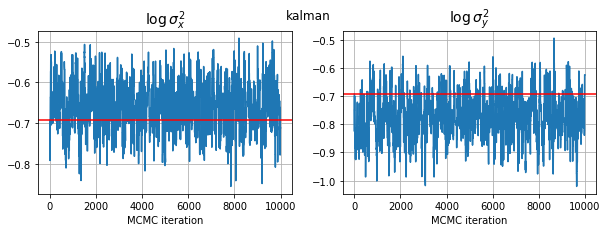

In [6]:
log_sigmay2_full, log_sigmax2_full, A_chain, C_chain, _, __ \
= adaptive_MH(Y, A, C, sigmax2, sigmay2, mu0, Sigma0, n_mcmc, scale, scale_A, scale_C, kappa=3e-1, adapt=False)

plot(log_sigmay2_full, log_sigmax2_full, sigmax2, sigmay2, "kalman")

In [54]:
full_MCMC = dict(sigmay2=log_sigmay2_full, sigmax2=log_sigmax2_full, A=A_chain, C=C_chain)
file = open("/xtmp/DC-BATS_data/linear_gaussian_HMM/full_mcmc.pkl", "wb")
pickle.dump(dat, file)
file.close()

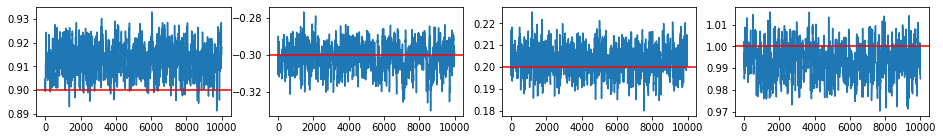

In [19]:
plt.rcParams['figure.figsize'] = (16, 2)
plt.subplot(141)
plt.plot(A_chain[:,0,0])
plt.axhline(y=A[0,0], color="red")
plt.subplot(142)
plt.plot(A_chain[:,0,1])
plt.axhline(y=A[0,1], color="red")
plt.subplot(143)
plt.plot(A_chain[:,1,0])
plt.axhline(y=A[1,0], color="red")
plt.subplot(144)
plt.plot(A_chain[:,1,1])
plt.axhline(y=A[1,1], color="red")

### Divide-and-conquer:

In [23]:
K = 5
tstarts = int(T/K)*np.arange(m).astype(int)
Ychunks = [Y[tstart:(int(T/K)+tstart)] for tstart in tstarts]
def f(y) :
    return adaptive_MH(y, A, C, sigmax2, sigmay2, mu0, Sigma0, n_mcmc, 
                       scale, scale_A, scale_C, power=K, method="kalman", adapt=False, kappa=3e-1)

In [24]:
pool = mp.Pool(K)
results = pool.map(f, [y for y in Ychunks])
pool.close()

10.0 % run in 1.1 mins; acceptance rate = 0.24
10.0 % run in 1.1 mins; acceptance rate = 0.11
10.0 % run in 1.1 mins; acceptance rate = 0.31
10.0 % run in 1.1 mins; acceptance rate = 0.34
10.0 % run in 1.1 mins; acceptance rate = 0.21
20.0 % run in 2.2 mins; acceptance rate = 0.24
20.0 % run in 2.2 mins; acceptance rate = 0.31
20.0 % run in 2.2 mins; acceptance rate = 0.1
20.0 % run in 2.3 mins; acceptance rate = 0.34
20.0 % run in 2.3 mins; acceptance rate = 0.22
30.0 % run in 3.3 mins; acceptance rate = 0.24
30.0 % run in 3.4 mins; acceptance rate = 0.1
30.0 % run in 3.4 mins; acceptance rate = 0.31
30.0 % run in 3.4 mins; acceptance rate = 0.34
30.0 % run in 3.4 mins; acceptance rate = 0.22
40.0 % run in 4.4 mins; acceptance rate = 0.24
40.0 % run in 4.5 mins; acceptance rate = 0.1
40.0 % run in 4.5 mins; acceptance rate = 0.31
40.0 % run in 4.5 mins; acceptance rate = 0.34
40.0 % run in 4.6 mins; acceptance rate = 0.22
50.0 % run in 5.6 mins; acceptance rate = 0.23
50.0 % run in 5.

In [56]:
for i in range(K) :
    chunk = dict(sigmay2=results[i][0], sigmax2=results[i][1], A=results[i][2], C=results[i][3])
    file = open("/xtmp/DC-BATS_data/linear_gaussian_HMM/mcmc_wb_chunk"+str(i+1)+".pkl", "wb")
    pickle.dump(dat, file)
    file.close()

In [25]:
xmax = np.max(np.asarray([np.max(results[i][0]) for i in range(K)]))
xmin = np.min(np.asarray([np.min(results[i][0]) for i in range(K)]))
ymax = np.max(np.asarray([np.max(results[i][1]) for i in range(K)]))
ymin = np.min(np.asarray([np.min(results[i][1]) for i in range(K)]))

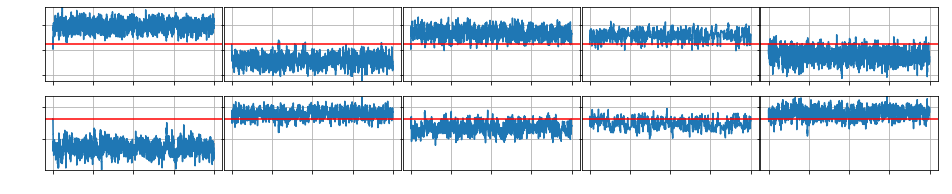

In [26]:
plt.rcParams['figure.figsize'] = (16, 3)
for i in range(K) :
    plt.subplot(2,K,i+1)
    plt.plot(results[i][0])
    plt.grid(True)
    plt.xticks(alpha=0)
    plt.yticks(alpha=0)
    plt.axhline(y=np.log(sigmax2), color="red")
    plt.ylim([xmin,xmax])
    
    plt.subplot(2,K,K+1+i)
    plt.plot(results[i][1])
    plt.grid(True)
    plt.xticks(alpha=0)
    plt.yticks(alpha=0)
    plt.axhline(y=np.log(sigmay2), color="red")
    plt.ylim([ymin,ymax])
plt.subplots_adjust(wspace=1e-2)

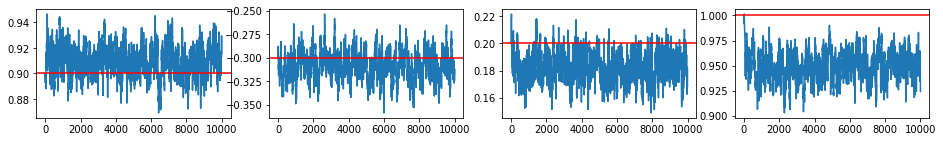

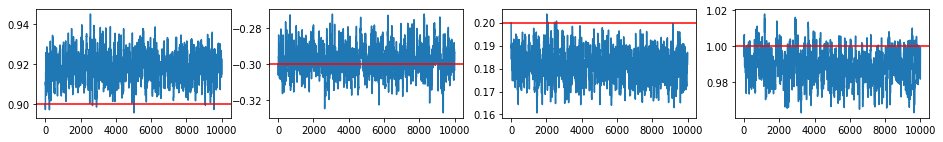

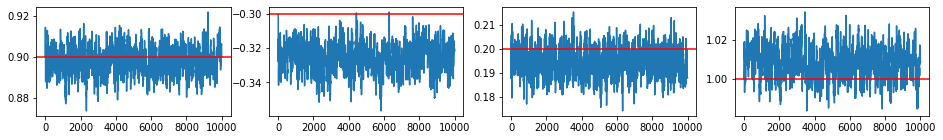

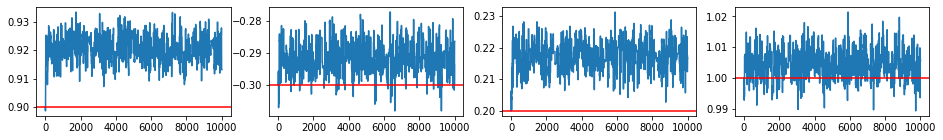

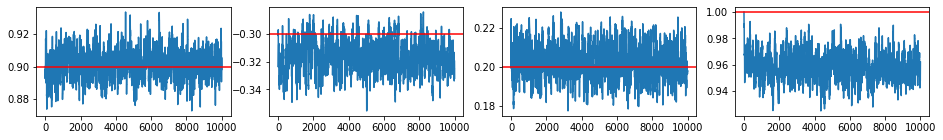

In [27]:
plt.rcParams['figure.figsize'] = (16, 2)
for i in range(K) :
    plt.subplot(141)
    plt.plot(results[i][2][:,0,0])
    plt.axhline(y=A[0,0], color="red")
    plt.subplot(142)
    plt.plot(results[i][2][:,0,1])
    plt.axhline(y=A[0,1], color="red")
    plt.subplot(143)
    plt.plot(results[i][2][:,1,0])
    plt.axhline(y=A[1,0], color="red")
    plt.subplot(144)
    plt.plot(results[i][2][:,1,1])
    plt.axhline(y=A[1,1], color="red")
    plt.show()

In [38]:
dc_ci = np.zeros((2,2))
dc_ci_A = np.zeros((2,*np.shape(A)))
for i in range(K) :
    dc_ci[0] += np.percentile(np.exp(results[i][0]), q=[2.5,97.5])/K
    dc_ci[1] += np.percentile(np.exp(results[i][1]), q=[2.5,97.5])/K
    dc_ci_A[:] += np.percentile(results[i][2], q=[2.5,97.5], axis=0)/K

In [41]:
print(np.percentile(np.exp(log_sigmay2_full), q=[2.5,97.5]))
print(np.percentile(np.exp(log_sigmax2_full), q=[2.5,97.5]))

[0.46404338 0.57630711]
[0.39768974 0.53803646]


In [42]:
print(dc_ci[0])
print(dc_ci[1])

[0.46299074 0.57216325]
[0.39644678 0.53967211]


In [43]:
print(np.percentile(A_chain, axis=0, q=[2.5,97.5]))
print(dc_ci_A)

[[[ 0.90060879 -0.31634977]
  [ 0.19130755  0.97918841]]

 [[ 0.92437649 -0.28754433]
  [ 0.21477247  1.00734966]]]
[[[ 0.89465872 -0.32688382]
  [ 0.18167383  0.96424589]]

 [[ 0.9245947  -0.28948299]
  [ 0.2094402   0.99983454]]]
